In [ ]:
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
import george
from george import kernels
import numpy as np
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as pl
import aflare as ap
import flaredetect as fd
import pandas as pd
from astropy.io import fits
from scipy.signal import savgol_filter as sf
from scipy.optimize import minimize
from numpy import asarray
import emcee

class Flare:
    flux = []
    time = []

    def __init__(self, x, y, r1, r2):

        self.flux = y[r1:r2]
        self.flux = self.flux[np.logical_not(np.isnan(self.flux))]
        self.flux = self.flux[np.logical_not(np.isinf(self.flux))]
        self.flux = self.flux.flatten()

        self.flux = (self.flux - min(self.flux)) / (max(self.flux) - min(self.flux))
        self.time = x[:len(self.flux)]
        self.time = self.time[np.logical_not(np.isnan(self.time))]
        self.flux = self.flux[:len(self.time)]



    def guesspeaks(self): # gathers the peaks in the set of data, then returns a list of flare times, peaks, and fwhm
        self.detflares = fd.flaredetectpeak(self.flux)
        self.flarecount = fd.getlength()
        self.nflares = np.shape(self.detflares)[0]
        self.params = np.zeros([self.nflares, 3])
        for i, flareVal in enumerate(self.detflares):
            self.flarepeak = flareVal
            self.flaretime = self.findfluxtime(self.flarepeak, self.flux, self.time)
            p = [self.flaretime, 0.0004, self.flarepeak]
            self.params[i, :] = p
        return np.log(self.params)


    def findfluxtime(self, flarepeak, flux, time):  # retrieves the time of the flare
        tof = time
        for i, flare in enumerate(flux):
            if flare == flarepeak:
                return tof[i]


    def getmodel(self, p, data): # computes the model of the flares using appaloosa's aflare1 function
        time, y, nflares = data
        p = np.exp(p)
        model = np.zeros_like([time])
        p = np.reshape(p, (nflares, 3))
        for i in range(nflares):
            model += ap.aflare1(time, tpeak=p[i, 0], fwhm=p[i, 1], ampl=p[i, 2], upsample=False, uptime=10)
        return model



def lnprob(p):
    # Trivial uniform prior.
    if np.any((-100 > p[1:]) + (p[1:] > 100)):
        return -np.inf

    # Update the kernel and compute the lnlikelihood.
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True)


'''George modeling'''
def computegeorge (flux, time):
    global gp
    global y

    y = flux
    x = time

    kernel = kernels.CosineKernel(log_period=np.log(3), axes=0) + kernels.ExpSquaredKernel(metric=0.5)
    gp = george.GP(kernel, mean=np.mean(y), fit_mean=True)
    gp.compute(x, y)
    print('Bounds', gp.get_parameter_bounds())
    print(gp.log_prior())
    print('Initial log likelihood', gp.log_likelihood(y))
    print('initial parameter vector', gp.get_parameter_vector())
    #res = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like, method="L-BFGS-B")
    #gp.set_parameter_vector(res.x)
    #print('Final log likelihood', gp.log_likelihood(y))
   # print('final parameter vector', res.x)
    #print(res)

    '''Emcee sampling'''
    # nwalkers, ndim = 36, len(gp)
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    #
    # # Initialize the walkers.
    # p0 = gp.get_parameter_vector() + 1e-4 * np.random.randn(nwalkers, ndim)
    #
    # print("Running burn-in")
    # p0, _, _ = sampler.run_mcmc(p0, 100)
    #
    # print("Running production chain")
    # sampler.run_mcmc(p0, 100)
    # print(sampler.flatchain[0][1])
    #
    # for i in range(ndim):
    #     pl.figure()
    #     pl.hist(sampler.flatchain[0, i], 100, color="k", histtype="step")
    #
    # pl.show()


    # for i in range(50):
    #     # Choose a random walker and step.
    #     w = np.random.randint(sampler.chain.shape[0])
    #     n = np.random.randint(sampler.chain.shape[1])
    #     gp.set_parameter_vector(sampler.chain[w, n])
    #     pl.plot(x, gp.sample_conditional(y, x))
    #
    #
    # pl.show()



    '''End emcee'''

    pred_mean, pred_var = gp.predict(y, x, return_var=True)

    pl.fill_between(time, pred_mean - np.sqrt(pred_var), pred_mean + np.sqrt(pred_var), color='k', alpha=0.4,
                    label='Predicted variance')

    pl.plot(flare.time, pred_mean, color='Blue', label='Predicted mean')
    pl.plot(flare.time, flare.flux, alpha=0.6, label='Raw flux')
    pl.ylim(0.0, 1)
    pl.ylabel("Relative Flux")
    pl.xlabel("BJD")
    pl.legend(loc='best')
    pl.show()
    pl.clf()

    #pred_mean, pred_var = gp.predict(y, x, return_var=True)

    pl.fill_between(time, pred_mean - np.sqrt(pred_var), pred_mean + np.sqrt(pred_var), color='k', alpha=0.4,
                    label='Predicted variance')

    pl.plot(flare.time, pred_mean, color='Blue', label='Predicted mean')
    # pl.plot(flare.time, flare.flux, alpha=0.6, label='Raw flux')
    pl.ylim(0.0, 1)
    pl.ylabel("Relative Flux")
    pl.xlabel("BJD")
    pl.legend(loc='best')
    pl.show()
    pl.clf()


    # x = np.linspace(max(x), 3120, 3095)
    # mu, var = gp.predict(flare.flux, x, return_var=True)
    #
    # std = np.sqrt(var)
    #
    # pl.plot(time, y, color="Blue")
    # pl.fill_between(x, mu + std, mu - std, color="k", alpha=0.5)
    #
    # pl.xlim(min(time), 3180)
    #
    # pl.show()


    # print(result)

    return pred_mean

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)


def setbounds(flux):
    flux = asarray(flux).ravel()
    bounds = np.zeros([len(flux),2])
    for i in range(len(flux)):
        for j in range(2):
            if j < 1:
                bounds[i][j] = flux[i]
            else:
                bounds[i][j] = flux[i] ** 1/20
    return bounds

'''End George Modeling'''

def remove_flares(flare):


    while len(fd.flaredetectpeak(flare.flux)) > 0:# while flares are still being detected, compute its model and subtract flares
        tempmodel = sub_flare_model(flare)
        pl.plot(flare.time, flare.flux)
        pl.plot(flare.time, tempmodel.flatten())
        pl.show()
        flare.flux = flare.flux-tempmodel.flatten()


        print("Flares subtracted!")


    return flare


def sub_flare_model(flare):
    guessparams = flare.guesspeaks()
    model = flare.getmodel(guessparams, [flare.time, flare.flux,
                                         flare.nflares])
    return model


def flatten(flare):
        # 113,008 points

        sf_model = sf(flare.flux, 501, 3)
        rotation = sf(sf_model, 501, 3)
        for i in range(10):
            rotation = sf(rotation, 501, 3)
        flat_flux = flare.flux - rotation
        flare.flux = flat_flux

        # smo = pd.rolling_median(flare.flux, 100, center=True)
        # smo2 = pd.rolling_median(flare.flux - smo, 2, center=True)


        pl.plot(flare.time, flare.flux)
        pl.show()
        remove_flares(flare)
        flare.flux += rotation



        return flare

def running_sum(list, window):
    j = 0
    new = 0
    new_list = []
    for i in range(len(list)):
        if j > window:
            new_list.append(new)
            new = 0
            j = 0
        else:
            new+=list[i]
            j+=1

    return new_list








print("Creating model...")
fits_file = fits.open('/Users/Dennis/Desktop/AuMicB/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits')


y = fits_file[1].data.field("PDCSAP_FLUX")[:]
x = fits_file[1].data.field("TIME")[:]



#flare = Flare(lc359, 0, len(lc359.flux))
flare = Flare(x, y, 0, len(y))

#print(flare.flux[9600:12000])


g = computegeorge(flare.flux, flare.time)
# pl.plot(flare.time, g, label='George model')
pl.plot(flare.flux)


Creating model...


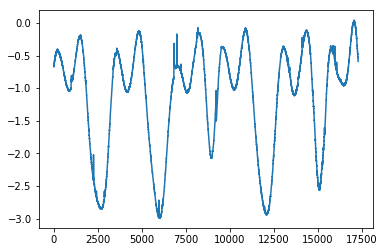

In [8]:
pl.plot(flare.flux)